In [1]:
# Librairies basiques d'exploitation et visualization de données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import random # Pour pouvoir mélanger notre jeu de données

In [3]:
# Modules pour le pré-processing
from qualitative_prep import Qual_Standardize
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA as ACP
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler, FunctionTransformer

from sklearn.utils import shuffle

# Module pour l'exploration de la projection factorielle
from fanalysis.pca import PCA

# Modèle pour la modélisation
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

# Module pour l'affichage
from sklearn import set_config
set_config(display="diagram")

# Librairie pour la lecture et enregistrement des modèles
import pickle

In [61]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("data_train.csv")

# Maison

On sélectionne uniquement les maisons

In [64]:
maison = df.loc[df["Type local"] == "Maison"]
maison.head(15)

,Valeur fonciere,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,exterieur,year,month,nom_region,pop_active,salaire_moyen,nb_etab_elem,mean_prixm2,q1_prixm2,q3_prixm2,Total_Mutations,Normalized_Mutations
0,90000.0,Maison,150.0,3,347.0,1.0,2018,1,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454
1,154200.0,Maison,180.0,6,680.0,1.0,2018,6,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454
2,181684.0,Maison,97.0,4,1050.0,1.0,2018,7,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454
3,149000.0,Maison,101.0,5,400.0,1.0,2018,8,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454
4,194550.0,Maison,80.0,4,846.0,1.0,2018,11,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454
6,145000.0,Maison,60.0,3,539.0,1.0,2019,7,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454
7,217815.0,Maison,122.0,5,973.0,1.0,2019,9,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454
8,191600.0,Maison,165.0,8,900.0,1.0,2019,10,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454
9,115000.0,Maison,99.0,4,365.0,1.0,2019,12,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454
10,167600.0,Maison,88.0,4,676.0,1.0,2020,1,Auvergne-Rhône-Alpes,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454


On calcule une estimation du prix en se basant sur le troisième quartile du département et sur la surface réelle du batiment

In [62]:
maison["estimated"] = maison["Surface reelle bati"] * maison["q3_prixm2"]

In [65]:
maison.drop(columns=["month", "nom_region", "Type local","Normalized_Mutations", "year"], inplace=True)

# Preprocessing

In [8]:
# On déclare nos variables quantitatives
quant_columns = ['Surface reelle bati', 'Nombre pieces principales',
       'Surface terrain','pop_active',
       'salaire_moyen', 'nb_etab_elem', "mean_prixm2","q1_prixm2","q3_prixm2","Total_Mutations", "estimated"]

# On déclare nos variables quantitatives
cat_columns = [ 'exterieur']

In [9]:
# On crée une première pipeline qui va centrer et réduire nos variables quantitatives
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())]
)


# On crée une seconde pipeline qui va créer un tableau disjonctif de notre variable qualitative puis la standardiser
categorical_transformer = Pipeline(
    steps=[("disjonctif", OneHotEncoder(handle_unknown="error")),
            ("standardize", Qual_Standardize())

    ]
)

# On crée un ColumnTransformer qui appliquera nos pipelines selon si elles sont qualitatives, quantitatives ou si c'est "Type local"
preprocessor = ColumnTransformer(
    transformers=[

        ("num", numeric_transformer, quant_columns),
        ("cat", categorical_transformer, cat_columns)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Surface reelle bati',
                                  'Nombre pieces principales',
                                  'Surface terrain', 'pop_active',
                                  'salaire_moyen', 'nb_etab_elem',
                                  'mean_prixm2', 'q1_prixm2', 'q3_prixm2',
                                  'Total_Mutations', 'estimated']),
                                ('cat',
                                 Pipeline(steps=[('disjonctif',
                                                  OneHotEncoder()),
                                                 ('standardize',
                                                  <qualitative_prep.Qual_Standardize object at 0x0000021583E7BAF0>)]),
                                 ['exterieur'])])

In [66]:
# On convertit notre variable extérieur en booléen.
maison["exterieur"] = maison["exterieur"].astype(bool)

In [11]:
# On extrait les variables exogènes
m_X = maison.iloc[:,1:]
m_X.head()

,Surface reelle bati,Nombre pieces principales,Surface terrain,exterieur,year,pop_active,salaire_moyen,nb_etab_elem,mean_prixm2,q1_prixm2,q3_prixm2,Total_Mutations,Normalized_Mutations,estimated
0,150.0,3,347.0,True,2018,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454,398078.723404
1,180.0,6,680.0,True,2018,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454,477694.468085
2,97.0,4,1050.0,True,2018,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454,257424.241135
3,101.0,5,400.0,True,2018,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454,268039.673759
4,80.0,4,846.0,True,2018,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,0.138454,212308.652482


In [13]:
# On extrait notre variable endogène
m_y = maison.iloc[:,0]
m_y.head()

0     90000.0
1    154200.0
2    181684.0
3    149000.0
4    194550.0
Name: Valeur fonciere, dtype: float64

In [14]:
# On divise notre jeu de données en un échantillon d'apprentissage et un test
m_X_train, m_X_test, m_y_train, m_y_test = train_test_split(m_X,m_y, test_size=0.33, random_state=1)

In [15]:
m_X_train.head()

,Surface reelle bati,Nombre pieces principales,Surface terrain,exterieur,pop_active,salaire_moyen,nb_etab_elem,mean_prixm2,q1_prixm2,q3_prixm2,Total_Mutations,estimated
446720,69.0,3,0.0,False,704471.0,17.033211,561,2055.237603,1484.527778,2603.405000,70721,179634.94500
1309010,116.0,5,532.0,True,170557.0,14.422626,280,1159.371171,981.865375,1335.425250,16678,154909.32900
1175728,118.0,5,1007.0,True,430354.0,15.720799,423,3934.983420,3232.874750,4374.729000,19899,516218.02200
446624,144.0,4,620.0,True,704471.0,17.033211,561,2055.237603,1484.527778,2603.405000,70721,374890.32000
16729,83.0,5,392.0,True,320682.0,15.336249,405,2235.777587,1662.166667,2653.858156,12389,220270.22695


In [16]:
m_y_train.head()

446720     202400.0
1309010    182500.0
1175728    425000.0
446624     290000.0
16729      230200.0
Name: Valeur fonciere, dtype: float64

In [17]:
# On applique notre pipeline de préprocessing à nos données
X_train_preprocessed = preprocessor.fit_transform(m_X_train, m_y_train)

In [18]:
# On récupère les noms de colonnes de notre tableau disjonctif de nos variables qualitatives
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['disjonctif'].get_feature_names_out(cat_columns)
cat_feature_names

array(['exterieur_False', 'exterieur_True'], dtype=object)

In [19]:
# On crée une liste avec toutes nos variables (dans l'ordre de la pipeline)
all_feature_names = np.concatenate([quant_columns, cat_feature_names])

In [20]:
# On transforme notre échantillon d'apprentissage
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_train_preprocessed

,Surface reelle bati,Nombre pieces principales,Surface terrain,pop_active,salaire_moyen,nb_etab_elem,mean_prixm2,q1_prixm2,q3_prixm2,Total_Mutations,estimated,exterieur_False,exterieur_True
0,-0.808898,-0.932187,-1.442560,0.841562,1.270022,0.188008,-0.008761,-0.167295,0.216137,2.238309,-0.400478,3.985727,0.000000
1,0.815961,0.747055,0.447732,-0.918177,-0.412205,-0.767722,-1.166339,-0.953459,-1.219091,-0.426733,-0.639928,0.000000,1.033043
2,0.885104,0.747055,2.135493,-0.061906,0.424320,-0.281354,2.420119,2.567120,2.221100,-0.267894,2.859091,0.000000,1.033043
3,1.783962,-0.092566,0.760412,0.841562,1.270022,0.188008,-0.008761,-0.167295,0.216137,2.238309,1.490432,0.000000,1.033043
4,-0.324898,0.747055,-0.049713,-0.423377,0.176521,-0.342575,0.224520,0.110532,0.273245,-0.638238,-0.006954,0.000000,1.033043
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623982,-0.394041,-0.092566,1.215220,-0.379963,-0.186477,-0.400395,-0.768293,-0.772860,-0.716838,-0.495327,-0.744501,0.000000,1.033043
623983,0.504818,-0.092566,2.135493,-0.639579,-0.564305,-0.322168,-0.777285,-0.691464,-0.798128,-0.602239,-0.370944,0.000000,1.033043
623984,0.435675,-1.771807,-0.344627,-0.617411,-0.002490,-0.737111,-0.666528,-0.728032,-0.602686,-0.750376,-0.228436,0.000000,1.033043
623985,-0.463183,-0.092566,-0.906029,-0.379963,-0.186477,-0.400395,-0.768293,-0.772860,-0.716838,-0.495327,-0.778961,0.000000,1.033043


# Après avoir standardisé, on applique l'ACP pour pouvoir réaliser l'AFDM (Analyse factorielle des données mixtes)

In [21]:
# On instantie notre ACP
my_pca = PCA(std_unit=True, row_labels=X_train_preprocessed.index.values, col_labels=X_train_preprocessed.columns.values)
my_pca

PCA(col_labels=array(['Surface reelle bati', 'Nombre pieces principales',
       'Surface terrain', 'pop_active', 'salaire_moyen', 'nb_etab_elem',
       'mean_prixm2', 'q1_prixm2', 'q3_prixm2', 'Total_Mutations',
       'estimated', 'exterieur_False', 'exterieur_True'], dtype=object),
    row_labels=array([     0,      1,      2, ..., 623984, 623985, 623986], dtype=int64))

In [22]:
# On la fait apprendre sur notre échantillon d'apprentissage 
my_pca.fit(X_train_preprocessed.values)
print(my_pca.eig_)

[[4.74766856e+00 2.47783228e+00 2.18227617e+00 1.73911750e+00
  6.79845944e-01 4.35868087e-01 3.58093526e-01 2.67495441e-01
  5.63806471e-02 2.74002685e-02 2.53646383e-02 2.65693294e-03
  7.34449697e-24]
 [3.65205274e+01 1.90602483e+01 1.67867398e+01 1.33778269e+01
  5.22958418e+00 3.35283144e+00 2.75456559e+00 2.05765724e+00
  4.33697285e-01 2.10771297e-01 1.95112602e-01 2.04379457e-02
  5.64961306e-23]
 [3.65205274e+01 5.55807757e+01 7.23675155e+01 8.57453424e+01
  9.09749266e+01 9.43277580e+01 9.70823236e+01 9.91399809e+01
  9.95736782e+01 9.97844495e+01 9.99795621e+01 1.00000000e+02
  1.00000000e+02]]


In [23]:
eigenvalues = pd.DataFrame({'eigenvalue' : my_pca.eig_[0]}) # Création d'un DataFrame à partir des valeurs propres du modèle AFC.
eigenvalues = eigenvalues.reset_index() # Nous appliquons reset_index() pour récupérer les labels des dimensions pour le diagramme en barres.

# Conversion de la colonne "index" en type catégorie
eigenvalues["index"] = eigenvalues["index"].astype("category")

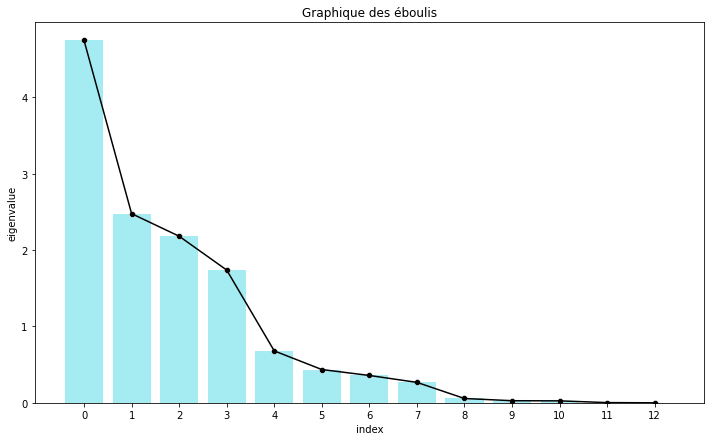

In [24]:
fig, axes = plt.subplots(figsize=(12, 7))
# Création d'un graphique à barres pour les valeurs propres.
sns.barplot(data=eigenvalues, x="index", y="eigenvalue", color="#98F5FF", ax=axes)
# Ajout d'un scatter plot pour les points des valeurs propres.
sns.scatterplot(data=eigenvalues, x="index", y="eigenvalue", color="black", ax=axes)
# Ajout d'une ligne pour connecter les points des valeurs propres.
sns.lineplot(data=eigenvalues, x="index", y="eigenvalue", color="black", ax=axes)
plt.title("Graphique des éboulis")
plt.show()


Nous pouvons nous rendre compte que nous avons une grande différence de valeurs propres après la quatrième composante (index 3) qui d'ailleurs passe sous le seuil de Kaiser-Guttman. Nous avons d'ailleurs un coude bien marqué à ce niveau là, nous retiendrons donc 4 composantes pour cette AFDM.

In [25]:
 # Création d'un DataFrame à partir des pourcentages d'inertie du modèle AFC.
pourcentage = pd.DataFrame({'pourcentage' : my_pca.eig_[1]})
pourcentage = pourcentage.reset_index() # Nous appliquons reset_index() pour récupérer les labels des dimensions pour le diagramme en barres.

pourcentage["index"] = pourcentage["index"].astype("category") # Conversion de la colonne "index" en type catégorie

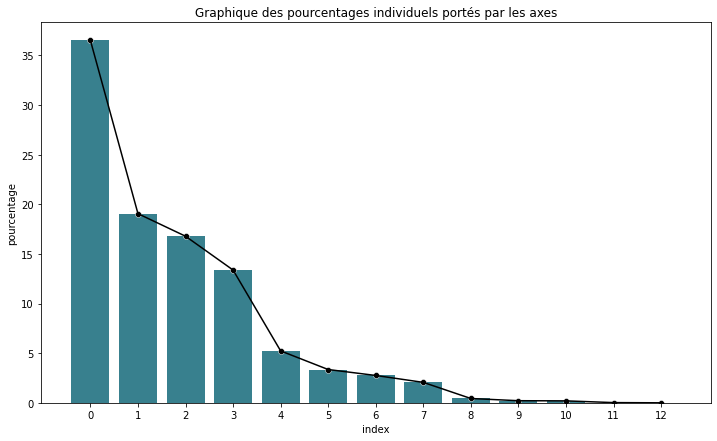

In [26]:
fig, axes = plt.subplots(figsize=(12, 7))
# Création d'un graphique à barres pour représenter les pourcentages.
sns.barplot(data=pourcentage, x="index", y="pourcentage", color="#2a8a9c", ax=axes)
# Création d'un graphique à barres pour représenter les pourcentages.
sns.scatterplot(data=pourcentage, x="index", y="pourcentage", color="black", ax=axes)
# Ajout d'une ligne pour connecter les points des pourcentages.
sns.lineplot(data=pourcentage, x="index", y="pourcentage", color="black", ax=axes)
# On obtient les valeurs minimales et maximales sur l'axe x.
xmin, xmax = axes.get_xlim() 
# On affiche une ligne horizontale qui représente le seuil de Kaiser.
plt.title("Graphique des pourcentages individuels portés par les axes")
plt.show()

In [27]:
cumsum = pd.DataFrame({'cumsum' : my_pca.eig_[2]}) # Création d'un DataFrame à partir des sommes cumulées d'inertie du modèle AFC.
cumsum = cumsum.reset_index() # Nous appliquons reset_index() pour récupérer les labels des dimensions pour le diagramme en barres.
# Conversion de la colonne "index" en type catégorie.
cumsum["index"] = cumsum["index"].astype("category")

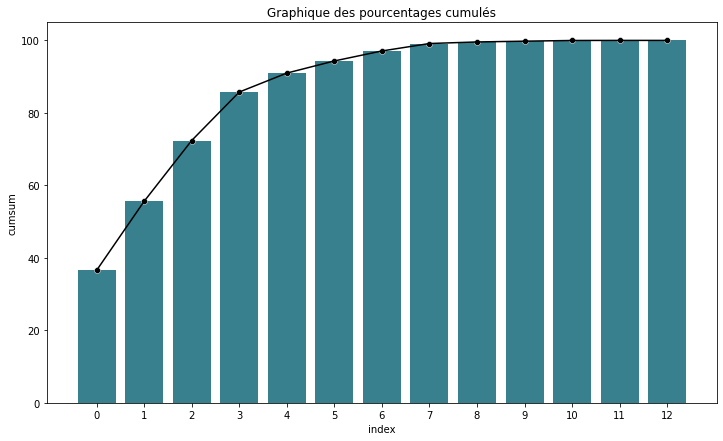

In [28]:
plt.figure(figsize=(12, 7))
# Création d'un graphique à barres pour représenter les pourcentages cumulés.
sns.barplot(data=cumsum, x="index", y="cumsum", color="#2a8a9c")
# Ajout d'un scatter plot pour les points des pourcentages cumulés.
sns.scatterplot(data=cumsum, x="index", y="cumsum", color="black")
# Ajout d'une ligne pour connecter les points des pourcentages cumulés.
sns.lineplot(data=cumsum, x="index", y="cumsum", color="black")
plt.title("Graphique des pourcentages cumulés")
plt.show()

In [29]:
# On extrait les valeurs en relation avec les variables
df_cols = my_pca.col_topandas()

In [30]:
# On extrait la contribution des variables à la définition des composantes
var_contrib = df_cols.iloc[:,13:17]
var_contrib

,col_contrib_dim1,col_contrib_dim2,col_contrib_dim3,col_contrib_dim4
Surface reelle bati,0.029745,18.490042,3.683765,19.532566
Nombre pieces principales,0.100042,14.648055,1.491572,20.059804
Surface terrain,0.754689,14.986693,0.863192,0.823333
pop_active,11.307453,0.254927,18.564622,0.934107
salaire_moyen,13.481947,0.018876,0.137872,1.033997
nb_etab_elem,4.498841,0.548696,29.145461,2.852810
mean_prixm2,17.403409,0.135332,3.989872,3.326572
q1_prixm2,16.284492,0.115330,4.928020,3.819557
q3_prixm2,17.749278,0.136790,3.231538,2.900036
Total_Mutations,5.928158,0.061999,22.307888,2.013358


In [31]:
# On extrait la qualité de représentation des variables sur les composantes
var_cos2 = df_cols.iloc[:,26:30]
var_cos2

,col_cos2_dim1,col_cos2_dim2,col_cos2_dim3,col_cos2_dim4
Surface reelle bati,0.001412,0.458152,0.080390,0.339694
Nombre pieces principales,0.004750,0.362954,0.032550,0.348864
Surface terrain,0.035830,0.371345,0.018837,0.014319
pop_active,0.536840,0.006317,0.405131,0.016245
salaire_moyen,0.640078,0.000468,0.003009,0.017982
nb_etab_elem,0.213590,0.013596,0.636034,0.049614
mean_prixm2,0.826256,0.003353,0.087070,0.057853
q1_prixm2,0.773134,0.002858,0.107543,0.066427
q3_prixm2,0.842677,0.003389,0.070521,0.050435
Total_Mutations,0.281449,0.001536,0.486820,0.035015


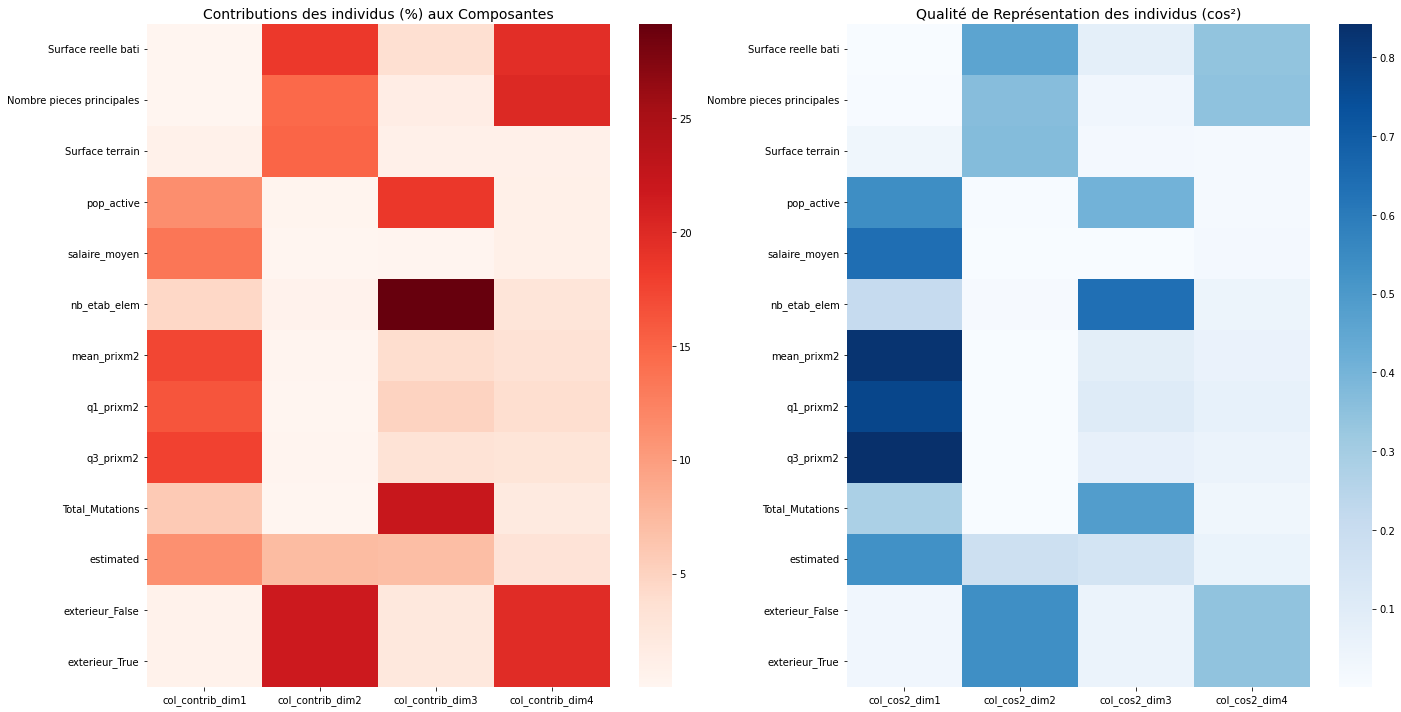

In [47]:
# On visualise les contributions et qualité de représentation grâce à des heatmaps.
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(ncols=2, nrows=1)

ax0 = fig.add_subplot(spec[0, 0])
sns.heatmap(var_contrib, cmap="Reds", ax=ax0)
ax0.set_title("Contributions des individus (%) aux Composantes", fontsize=14)

ax1 = fig.add_subplot(spec[0, 1])
sns.heatmap(var_cos2, cmap="Blues", ax=ax1)
ax1.set_title("Qualité de Représentation des individus (cos²)", fontsize=14)


plt.tight_layout()
plt.show()

In [48]:
df_rows = my_pca.row_topandas()
ind_coord = df_rows.iloc[:,0:4]
# Pour chaque facteur, on calcule la corrélation
for col in ind_coord.columns:
    coef = np.corrcoef(m_y_train, ind_coord[col])
    print(coef)

[[1.         0.51463962]
 [0.51463962 1.        ]]
[[ 1.         -0.24223616]
 [-0.24223616  1.        ]]
[[1.         0.23214319]
 [0.23214319 1.        ]]
[[ 1.         -0.10472013]
 [-0.10472013  1.        ]]


On retrouve une corrélation élevée entre la première composante et les valeurs foncières. Une corrélation modérée avec la grandeur du terrain (négative )et 

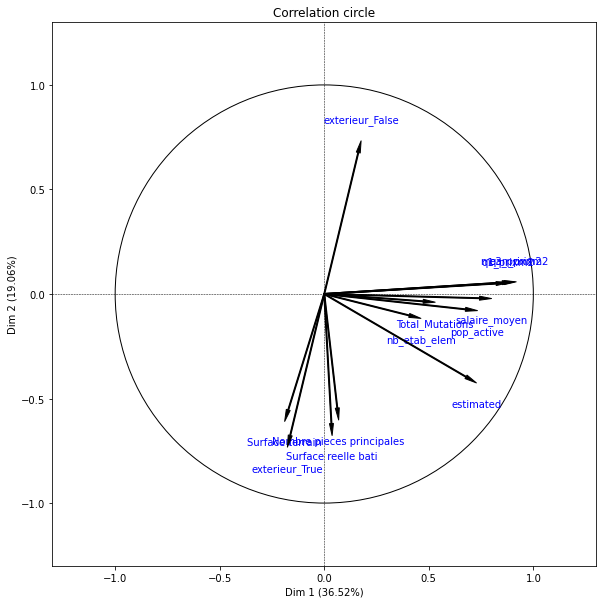

In [49]:
my_pca.correlation_circle(num_x_axis=1, num_y_axis=2, figsize=(20, 10))

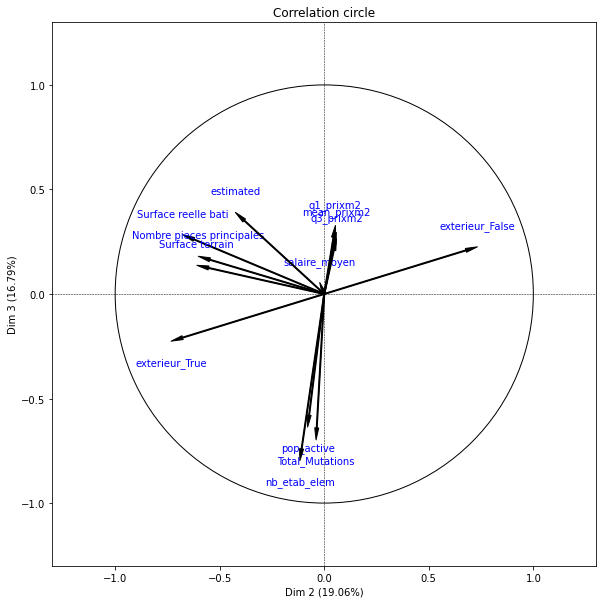

In [45]:
my_pca.correlation_circle(num_x_axis=2, num_y_axis=3, figsize=(20, 10))

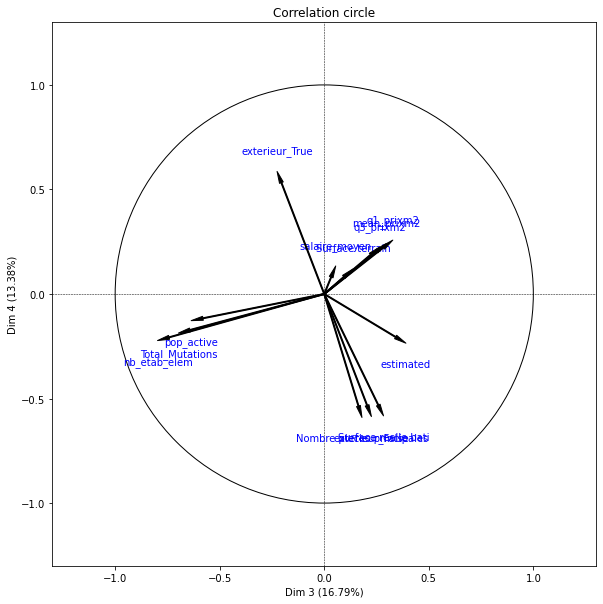

In [46]:
my_pca.correlation_circle(num_x_axis=3, num_y_axis=4, figsize=(20, 10))

Comme pour les locaux, la première composante semble être reliée positivement au prix au m2 du bien et le salaire moyen horaire dans le département. Elle semble être liée à la **richesse du département.** La seconde composante semble plutôt liée avec l'**absence d'un terrain**. La troisième composante enfin semble plutôt liée avec des caractéristiques démographiques de grandes agglomérations (nombre d'écoles élémentaires élevé, nombre de vente de biens par département élevé et pourcentage de population active élevé). Notre quatrième composante semble reprendre de l'information non expliquée par la deuxième composante en se corrélant positivement avec **la présence d'un terrain**. 

# Pipeline pour le préprocessing avant la prédiction

In [34]:
afdm = Pipeline(
    steps=[("preprocessor", preprocessor), ("factorial", ACP(n_components=4))]
)
afdm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Surface reelle bati',
                                                   'Nombre pieces principales',
                                                   'Surface terrain',
                                                   'pop_active',
                                                   'salaire_moyen',
                                                   'nb_etab_elem',
                                                   'mean_prixm2', 'q1_prixm2',
                                                   'q3_prixm2',
                                                   'Total_Mutations',
                                                   'estimated']),
                                                 ('cat',
                                                  Pipeline(steps=[('disjonctif',
                                                                   OneHotEncoder()),
                                                                  ('standardize',
                                                                   <qualitative_prep.Qual_Standardize object at 0x0000021583E7BAF0>)]),
                                                  ['exterieur'])])),
                ('factorial', PCA(n_components=4))])

In [36]:
# On fait apprendre notre pipeline sur notre échantillon d'apprentissage
m_X_train_afdm = pd.DataFrame(afdm.fit_transform(m_X_train))
m_X_train_afdm.head()

,0,1,2,3
0,1.515417,-2.900485,0.235615,3.005576
1,-2.342697,1.049465,-0.531917,0.217054
2,3.828194,3.317707,1.231732,-1.207466
3,1.832102,0.958366,-1.920786,-0.129831
4,-0.050066,0.581371,0.574688,-0.095320


In [37]:
# On extrait la pipeline de préprocessign qui a apprise sur notre échantillon d'entrainement.
preprocessing_pkl_file = "maison_preprocessing2.pkl"  

with open(preprocessing_pkl_file, 'wb') as file:  
    pickle.dump(afdm, file)

In [38]:
# On remet l'index de y_train à 0 pour s'aligner avec notre X_train transformée.
m_y_train= m_y_train.reset_index().drop(columns=["index"])["Valeur fonciere"]

In [39]:
# On transforme notre échantillon test en utilisant les informations tirées de l'échantillon d'apprentissage
X_test_afdm = pd.DataFrame(afdm.transform(m_X_test))
X_test_afdm.head()

,0,1,2,3
0,1.720249,-0.024470,-4.384909,-0.764697
1,-0.761740,1.634004,1.177461,0.936531
2,-0.461348,1.046834,-0.192833,0.236571
3,1.282648,-4.105854,-2.540792,-0.241715
4,-0.792592,-1.680202,-0.953455,-0.462030


# Prédiction avec un modèle linéaire

In [40]:
epoch = 10 # On établit combien de fois notre jeu de données passera entièrement par notre modèle de regression
batch_size =  2**8
num_samples = len(m_X_train_afdm) # On décrit la taille de l'échantillon d'apprentissage

In [49]:
mse_list=[]

In [53]:
for eta in [1, 0.01, 0.001]:
    print(f'Eta0 en cours: {eta}')
    for alpha_val in [0.0001, 0.001, 0.01]:
        print(f'Alpha en cours: {alpha_val}')
        for l1_rat in [0, 0.25, 0.5, 0.75,1]:
            print(f'L1 en cours: {l1_rat}')
            sgd_regressor = SGDRegressor(loss='squared_error', penalty="elasticnet", alpha=alpha_val,learning_rate='optimal', eta0=eta, l1_ratio=l1_rat, shuffle=False)
            for k in range(1,epoch+1):
                    # On affiche la progression
                    progress = (k/epoch)*100  
                    print(f'Progression: Epoch {k}/{epoch} /  {progress}%')  

                    # On mélange notre jeu de données 
                    X_shuffled, y_shuffled = shuffle(m_X_train_afdm, m_y_train)

                    # Pour chaque mini-batch, fait apprendre ce groupe de données au modèle grâce au partial_fit
                    for i in range(0, num_samples, batch_size):                    
                        X_mini_batch = X_shuffled[i:i+batch_size]
                        y_mini_batch = y_shuffled[i:i+batch_size]

                        # Tant que la taille du batch n'est pas égal à zéro, on continue
                        if len(X_mini_batch) > 0:
                            sgd_regressor.partial_fit(X_mini_batch, y_mini_batch)
                        else:
                            break

                # On prédit les valeurs de y pour l'échantillon test
            y_pred = sgd_regressor.predict(X_test_afdm)
                    # On extrait la moyenne des résidus au carré
            mse = mean_squared_error(m_y_test, y_pred)
                    # On affiche le socre du modèle.
            mse_list.append(mse)
            print(f"Mean Squared Error: {mse}")

Eta0 en cours: 1
Alpha en cours: 0.0001
L1 en cours: 0
Progression: Epoch 1/10 /  10.0%
Progression: Epoch 2/10 /  20.0%
Progression: Epoch 3/10 /  30.0%
Progression: Epoch 4/10 /  40.0%
Progression: Epoch 5/10 /  50.0%
Progression: Epoch 6/10 /  60.0%
Progression: Epoch 7/10 /  70.0%
Progression: Epoch 8/10 /  80.0%
Progression: Epoch 9/10 /  90.0%
Progression: Epoch 10/10 /  100.0%
Mean Squared Error: 5682068779.416848
L1 en cours: 0.25
Progression: Epoch 1/10 /  10.0%
Progression: Epoch 2/10 /  20.0%
Progression: Epoch 3/10 /  30.0%
Progression: Epoch 4/10 /  40.0%
Progression: Epoch 5/10 /  50.0%
Progression: Epoch 6/10 /  60.0%
Progression: Epoch 7/10 /  70.0%
Progression: Epoch 8/10 /  80.0%
Progression: Epoch 9/10 /  90.0%
Progression: Epoch 10/10 /  100.0%
Mean Squared Error: 5685801370.241383
L1 en cours: 0.5
Progression: Epoch 1/10 /  10.0%
Progression: Epoch 2/10 /  20.0%
Progression: Epoch 3/10 /  30.0%
Progression: Epoch 4/10 /  40.0%
Progression: Epoch 5/10 /  50.0%
Progr

In [54]:
min(mse_list)

5661267335.880737

On récupère notre modèle  avec les hyperparamètres nous ayant donné la valeur de MSE la plus basse.

In [41]:
epoch = 10 # On établit combien de fois notre jeu de données passera entièrement par notre modèle de regression
batch_size =  2**6
num_samples = len(m_X_train_afdm) # On décrit la taille de l'échantillon d'apprentissage

In [42]:
sgd_regressor = SGDRegressor(loss='squared_error', penalty="elasticnet", alpha=0.001,learning_rate='optimal', eta0=0.001, l1_ratio=0.5, shuffle=False)
for k in range(1,epoch+1):
                    # On affiche la progression
                    progress = (k/epoch)*100  
                    print(f'Progression: Epoch {k}/{epoch} /  {progress}%')  

                    # On mélange notre jeu de données 
                    X_shuffled, y_shuffled = shuffle(m_X_train_afdm, m_y_train)

                    # Pour chaque mini-batch, fait apprendre ce groupe de données au modèle grâce au partial_fit
                    for i in range(0, num_samples, batch_size):                    
                        X_mini_batch = X_shuffled[i:i+batch_size]
                        y_mini_batch = y_shuffled[i:i+batch_size]

                        # Tant que la taille du batch n'est pas égal à zéro, on continue
                        if len(X_mini_batch) > 0:
                            sgd_regressor.partial_fit(X_mini_batch, y_mini_batch)
                        else:
                            break

                # On prédit les valeurs de y pour l'échantillon test
y_pred = sgd_regressor.predict(X_test_afdm)
                    # On extrait la moyenne des résidus au carré
mse = mean_squared_error(m_y_test, y_pred)
                    # On affiche le socre du modèle.
print(f"Mean Squared Error: {mse}")

Progression: Epoch 1/10 /  10.0%
Progression: Epoch 2/10 /  20.0%
Progression: Epoch 3/10 /  30.0%
Progression: Epoch 4/10 /  40.0%
Progression: Epoch 5/10 /  50.0%
Progression: Epoch 6/10 /  60.0%
Progression: Epoch 7/10 /  70.0%
Progression: Epoch 8/10 /  80.0%
Progression: Epoch 9/10 /  90.0%
Progression: Epoch 10/10 /  100.0%
Mean Squared Error: 5664080522.031708


On extrait les coefficients du modèle.

In [43]:
sgd_regressor.coef_

array([22618.51887065, 21470.71917056,  -435.2988959 ,  1347.45524061])

Comme nos variables exogènes pour notre modèle de régression proviennent de l'AFDM, ils sont de la même unité et nous pouvons donc les comparer. Nous utilisons donc la valeur absolue des coefficients pour étudier leur importance dans le modèle.

In [59]:
feat_import = pd.DataFrame({"importance": abs(sgd_regressor.coef_), "variables": ["Richesse Département", "Absence de terrain", "Niveau Démographique", "Présence de terrain" ]}).sort_values(by="importance", ascending=False)
feat_import

,importance,variables
0,22618.518871,Richesse Département
1,21470.719171,Absence de terrain
3,1347.455241,Présence de terrain
2,435.298896,Niveau Démographique


<Axes: xlabel='importance', ylabel='variables'>

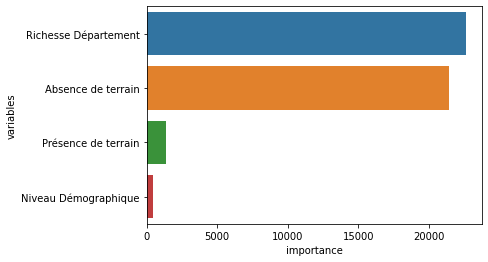

In [60]:
sns.barplot(data=feat_import,  x="importance",y="variables")

C'est la richesse de département et l'absence de terrain qui sont déterminant pour le modèle pour prédire la valeur foncière. 

In [62]:
# On 
model_pkl_file = "maison_model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(sgd_regressor, file)

In [ ]:
# On crée un dataframe avec nos valeurs prédites, observées et nos résidus.
df_graph = pd.DataFrame({'predicted':  y_pred,
              'observed': m_y_test,
              'residual': m_y_test - y_pred})

df_graph.head(30)

,predicted,observed,residual
953052,230019.877200,185000.0,-45019.877200
36780,210239.541410,160000.0,-50239.541410
886132,203689.401705,115000.0,-88689.401705
969623,130812.322287,147000.0,16187.677713
1017235,135585.926398,83000.0,-52585.926398
1044179,213560.748089,100000.0,-113560.748089
784153,178147.191447,235000.0,56852.808553
761563,194925.327550,238000.0,43074.672450
638520,171714.720152,218900.0,47185.279848
704552,218348.457906,355000.0,136651.542094


Nous pouvons observer que le modèle faillit à vraiment bien prédire la valeur de tous les biens. Comme nous le montre les résidus ci dessus et le graphique ci-dessous, il existe sans doute d'autres variables qui influencent la valeur foncière. Certainement, il existe des intéractions entre les variables.

<Axes: xlabel='predicted', ylabel='observed'>

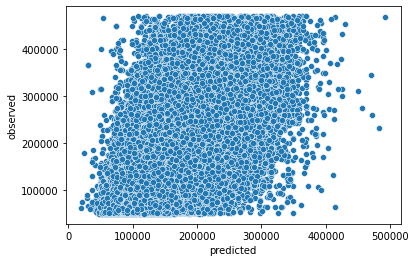

In [ ]:
sns.scatterplot(data=df_graph, x="predicted", y="observed")

In [ ]:
m_X_test[m_X_test.index == 702050].iloc[0]

Surface reelle bati                 88.0
Nombre pieces principales              2
Surface terrain                    574.0
exterieur                           True
year                                2021
pop_active                      693553.0
salaire_moyen                  15.831803
nb_etab_elem                         634
mean_prixm2                  2471.561903
q1_prixm2                      1861.5725
q3_prixm2                       2935.536
Total_Mutations                    54340
Normalized_Mutations             0.60728
estimated                     258327.168
Name: 702050, dtype: object